<a href="https://colab.research.google.com/github/dataconfines/Predicting-Computer-Prices-using-Machine-Learning/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: This synthetic dataset is modeled after an existing milling machine and consists of 10 000 data points from a stored as rows with 14 features in columns.
# 1- UID: unique identifier ranging from 1 to 10000
# 2- product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
# 3- type: just the product type L, M or H from column 2
# 4- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
# 5- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
# 6- rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
# 7- torque [Nm]: torque values are normally distributed around 40 Nm with a SD = 10 Nm and no negative values.
# 8-tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
# 9- 'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.
# The machine failure consists of five independent failure modes
# 1- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
# 2- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm. This is the case for 115 data points.
# 3- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
# 4- overstrain failure (OSF): if the product

# The last 5 columns of the dataset are binary indicators of the individual failure modes: TWF, HDF, PWF, OSF, RNF.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Notebooks/AI4I_2020_Predictive_Maintenance/ai4i2020.csv')

In [ ]:
df.sample(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
8347,8348,L55527,L,298.7,309.6,1665,31.1,178,0,0,0,0,0,0
966,967,M15826,M,295.8,306.5,1641,32.2,101,0,0,0,0,0,0
6103,6104,L53283,L,300.8,310.8,1407,45.1,51,0,0,0,0,0,0
4181,4182,M19041,M,302.4,310.7,1521,40.4,152,0,0,0,0,0,0
6372,6373,M21232,M,300.0,309.5,1879,22.4,79,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [ ]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [ ]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [ ]:
#

In [ ]:
df=df.drop(['UDI','Product ID'],axis=1)

In [ ]:
X=df.drop('Machine failure',axis=1)
y=df['Machine failure']

In [ ]:
categoric_column=X.select_dtypes(include='object').columns
numeric_column=X.select_dtypes(exclude='object').columns

In [ ]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
categorical_transformer=Pipeline(steps=[('onehot',OneHotEncoder(handle_unknown='ignore'))])
numeric_transformer=Pipeline(steps=[('scaler',StandardScaler())])

In [ ]:
preprecossor=ColumnTransformer(transformers=[('num',numeric_transformer,numeric_column),
                                             ('cat',categorical_transformer,categoric_column)])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier


In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,precision_recall_curve ,precision_score,recall_score,f1_score

In [ ]:
models={
    'RandomForestClassifier':RandomForestClassifier(),
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'AdaBoostClassifier':AdaBoostClassifier(),
    'XGBClassifier':XGBClassifier(),

    'VotingClassifier':VotingClassifier(
        estimators=[
            ('rf',RandomForestClassifier()),
            ('gb',GradientBoostingClassifier()),
            ('ada',AdaBoostClassifier()),
            ('xgb',XGBClassifier())
        ],
        voting='hard'
    )
}

In [ ]:
result=[]
cm_data=[]
roc_curve_data=[]
pr_curve_data=[]

In [ ]:

for name , model in models.items() :
  pipeline=Pipeline(
      steps=[
          ('preprecossor',preprecossor),
          ('model',model)
      ]
  )
  pipeline.fit(X_train,y_train)
  y_pred=pipeline.predict(X_test)
  # Evalution model
  acc=accuracy_score(y_test,y_pred)
  prec=precision_score(y_test,y_pred,zero_division=0)
  recall=recall_score(y_test,y_pred,zero_division=0)
  f1=f1_score(y_test,y_pred,zero_division=0)
  result.append([name,acc,prec,recall,f1])
  # confusion matrix
  cm=confusion_matrix(y_test,y_pred)
  cm_data.append([name,confusion_matrix(y_test,y_pred)])
   # roc curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_data.append({
      'model':name,
      'fpr':fpr,
      'tpr':tpr
  })
  # pr_curve
  pr_curve=precision_recall_curve(y_test,y_pred)
  pr_curve_data.append({
      'model':name,
      'precision':pr_curve[0],
      'recall':pr_curve[1]
  })


In [ ]:
result_df=pd.DataFrame(result,columns=['model','accuracy','precision','recall','f1'])

In [ ]:
result_df

,model,accuracy,precision,recall,f1
0,RandomForestClassifier,0.9990,1.000000,0.967213,0.983333
1,GradientBoostingClassifier,0.9985,0.983333,0.967213,0.975207
2,DecisionTreeClassifier,0.9975,0.951613,0.967213,0.959350
3,AdaBoostClassifier,0.9945,1.000000,0.819672,0.900901
4,XGBClassifier,0.9990,1.000000,0.967213,0.983333
5,VotingClassifier,0.9990,1.000000,0.967213,0.983333


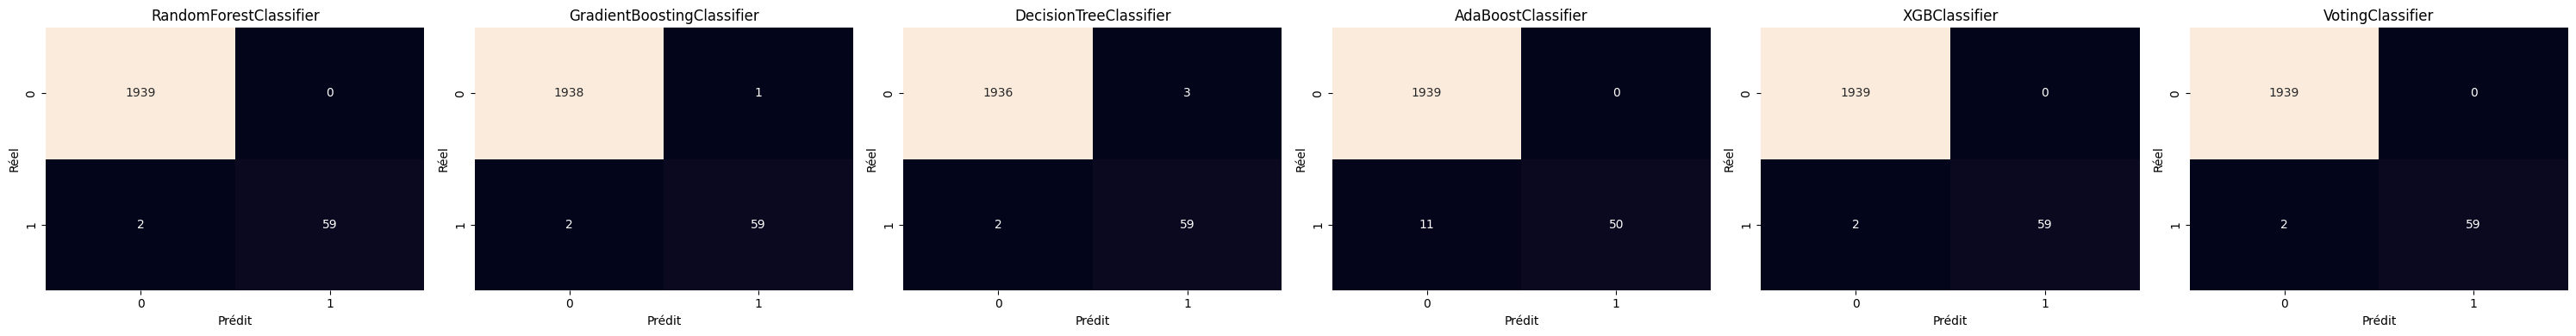

In [ ]:
n_models = len(cm_data)

fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

if n_models == 1:
    axes = [axes]
for ax, (name, cm) in zip(axes, cm_data):
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Prédit")
    ax.set_ylabel("Réel")

plt.tight_layout()
plt.show()

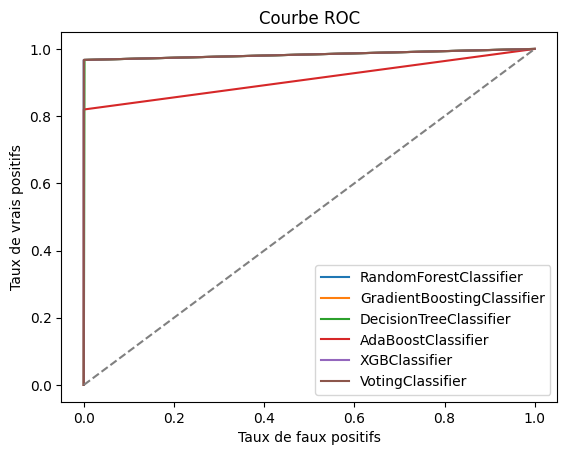

In [ ]:
for roc_curve_data in roc_curve_data:
    model_name = roc_curve_data['model']
    fpr = roc_curve_data['fpr']
    tpr = roc_curve_data['tpr']
    plt.plot(fpr, tpr, label=model_name)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()

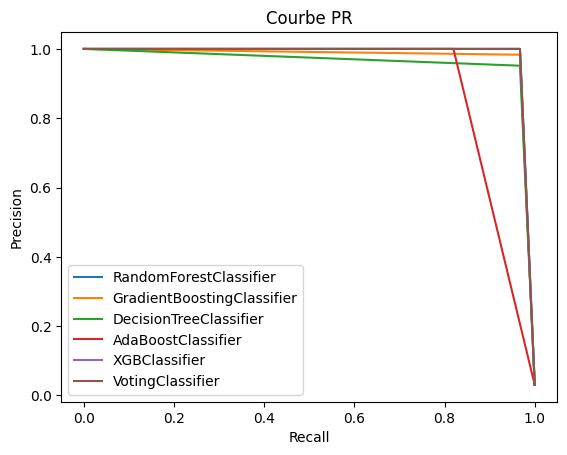

In [ ]:
for pr_curve_data in pr_curve_data:
    model_name = pr_curve_data['model']
    precision = pr_curve_data['precision']
    recall = pr_curve_data['recall']
    plt.plot(recall, precision, label=model_name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe PR')
plt.legend()
plt.show()

In [ ]:

X_train = X_train_encoded.to_numpy().astype('float32')
X_test = X_test_encoded.to_numpy().astype('float32')

y_train = pd.Series(y_train).astype('float32').to_numpy()
y_test = pd.Series(y_test).astype('float32').to_numpy()

In [ ]:
import tensorflow

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model
from tensorflow.keras.optimizers import AdamW

In [ ]:
ann=Sequential()
ann.add(Dense(units=128, activation='relu', input_shape=(X_train.shape[1],)))
ann.add(Dense(units=64,activation='relu'))
ann.add(Dense(units=16,activation='relu'))
ann.add(Dense(units=1,activation='sigmoid'))

In [ ]:
ann.compile(optimizer='AdamW',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history =ann.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9284 - loss: 1.0306 - val_accuracy: 0.9695 - val_loss: 0.3589
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9550 - loss: 0.3644 - val_accuracy: 0.9695 - val_loss: 0.1250
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9560 - loss: 0.2204 - val_accuracy: 0.9695 - val_loss: 0.2203
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9664 - loss: 0.1372 - val_accuracy: 0.9695 - val_loss: 0.2491
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9614 - loss: 0.1625 - val_accuracy: 0.9645 - val_loss: 0.1402
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9658 - loss: 0.1443 - val_accuracy: 0.9710 - val_loss: 0.1229
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9693 - loss: 0.1211 - val_accuracy: 0.8095 - val_loss: 0.4431
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9658 - loss: 0.1586 - val_accuracy: 0.

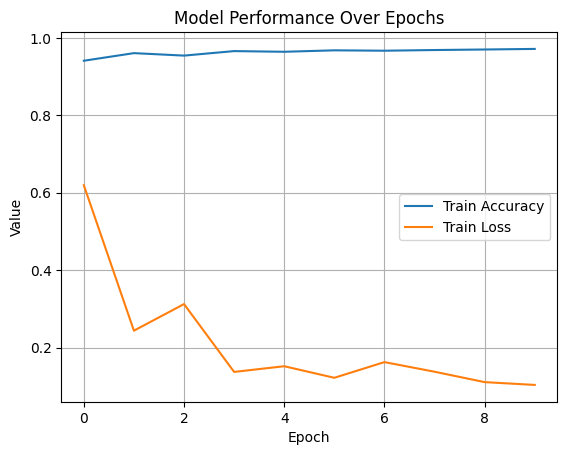

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Model Performance Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred_binary = (y_pred > 0.5).astype("int32")

from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(cm)

acc = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy: {acc:.4f}")

Confusion Matrix:
[[1939    0]
 [   2   59]]

Accuracy: 0.9990
